In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib inline

In [2]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import gridspec

import fastcluster
from scipy.cluster.hierarchy import dendrogram
import scipy.cluster.hierarchy as hier

import networkx as nx

# ATB vs LTBI 

Load *significant* logFC changes for genes between ATB & LTBI samples collected from various studies

In [3]:
#use this path for personal computer
microarray_diff_exp_data = "/Users/rogervargas/OneDrive - Bill & Melinda Gates Medical Research Institute/Projects/Biomarkers/Data/Pooled Differential Gene Expression/"

#use this path for Gates MRI computer
#microarray_diff_exp_data = "/Users/RogerVargas/OneDrive - Bill & Melinda Gates Medical Research Institute/Projects/Biomarkers/Pooled Differential Gene Expression/"

diff_gene_exp_df = pd.read_csv(microarray_diff_exp_data + 'ATB_v_LTBI_signif_logFC_across_studies.csv').set_index('Unnamed: 0')
diff_gene_exp_df.rename_axis('gene' , inplace = True)

In [4]:
diff_gene_exp_df.head()

,GSE19439,GSE19442,GSE19444,GSE28623,GSE37250,GSE39939,GSE39940,GSE41055,GSE50834,GSE54992,GSE62525,GSE69581,GSE73408,GSE84076,GSE101705,GSE107994
gene,,,,,,,,,,,,,,,,
DUSP5,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
FBP2,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
C15orf37,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
PHB,0.0,-0.691022,0.0,-0.679743,0.0,-0.732874,-0.604802,0.0,0.0,0.810369,0.0,0.0,0.0,0.0,0.0,0.0
ZNF689,0.0,0.000000,0.0,-0.793707,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


### Construct simplified matrix of logFC *direction* from DataFrame with significant logFC changes across all analyses by converting values:
   1. $+1$ if logFC > 0
   1. $0$ if logFC = 0
   1. $-1$ if logFC < 0

In [5]:
#store copy of array from dataframe with sig. logFC values (rows = genes, columns = GSE ID)
direc_diff_gene_exp_matrix = diff_gene_exp_df.copy().values 

#replace values in logFC matrix
direc_diff_gene_exp_matrix[direc_diff_gene_exp_matrix > 0.0] = 1
direc_diff_gene_exp_matrix[direc_diff_gene_exp_matrix == 0.0] = 0
direc_diff_gene_exp_matrix[direc_diff_gene_exp_matrix < 0.0] = -1

#convert to lower memory int8 datatype
direc_diff_gene_exp_matrix = direc_diff_gene_exp_matrix.astype('int8')

In [6]:
direc_diff_gene_exp_matrix

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int8)

In [7]:
np.shape(direc_diff_gene_exp_matrix)

(30641, 16)

### Compute the dot product between every two pairs of gene vectors (will calculate the edges weights for our network)
### Compute $M \cdot M^T \text{ to get } i \cdot j \text{ , } \forall \text{ pairs of rows } i, j \text{ in matrix } M$ 

In [8]:
#multiply direction logFC matrix by its transpose to get the dot products between all pairs of rows
network_edge_weight_matrix = direc_diff_gene_exp_matrix.dot(direc_diff_gene_exp_matrix.T)

#the row/column annotation (genes) can be copied from the logFC differential gene expression DataFrame
network_edge_weight_matrix_labels = pd.Series(list(diff_gene_exp_df.index) , index = range(0 , len(diff_gene_exp_df.index)))

In [9]:
network_edge_weight_matrix

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int8)

In [10]:
np.shape(network_edge_weight_matrix)

(30641, 30641)

In [11]:
network_edge_weight_matrix_labels.head()

0       DUSP5
1        FBP2
2    C15orf37
3         PHB
4      ZNF689
dtype: object

In [12]:
np.shape(network_edge_weight_matrix_labels)

(30641,)

### Investigate sparsity of matrix

In [13]:
float(np.sum(network_edge_weight_matrix == 0)) / float(np.shape(network_edge_weight_matrix)[0]*np.shape(network_edge_weight_matrix)[1])

0.9356423314187332

The matrix has ~93.5% sparsity, when constructing the network, we will **only** connect nodes (genes) with weights that are **non-zero** values. 

In [33]:
print( 'Number of Non-Zero entries ~ ' + str(int(float(np.sum(network_edge_weight_matrix != 0))/2.0)) )

Number of Non-Zero entries ~ 30211770


### Investigate the distribution of the Edge Weights

In [34]:
#Return the upper triangular part of the matrix with elements in lower part zeroed out
upper_tri_network_edge_weight_matrix = np.triu(network_edge_weight_matrix, k = 0)

#Return all non-zero elements
edge_weight_array = upper_tri_network_edge_weight_matrix[np.nonzero(upper_tri_network_edge_weight_matrix)]

In [71]:
edge_weight_array

array([ 5,  1,  3, ..., -1,  3,  1], dtype=int8)

How many edges are non-zero?

In [72]:
len(edge_weight_array)

30217928

How many edges are there with an abs(edge weight) $\ge 6$?

In [116]:
np.sum(edge_weight_array <= -6)

82125

In [117]:
np.sum(edge_weight_array >= 6)

89548

What is the range of edge weights that are non-zero?

In [37]:
np.min(edge_weight_array)

-13

In [38]:
np.max(edge_weight_array)

14

In [39]:
plt.style.use('ggplot')
plt.rcParams['lines.linewidth']=1.0
plt.rcParams['axes.facecolor']='1.0'
plt.rcParams['xtick.color']='black'
plt.rcParams['axes.grid']=False
plt.rcParams['axes.edgecolor']='black'
plt.rcParams['grid.color']= '1.0'
plt.rcParams.update({'font.size': 14})

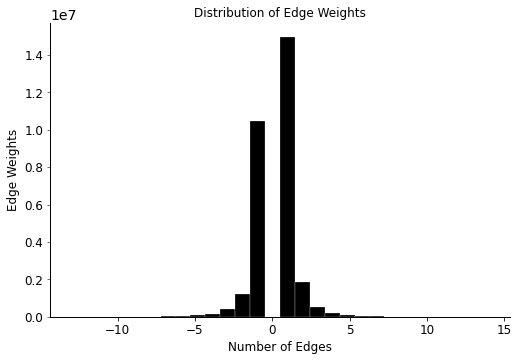

In [40]:
fig , ax = plt.subplots()

n , bins , patches = plt.hist(edge_weight_array , bins = 28 , color = 'k' , rwidth = 1.0 , edgecolor='white', linewidth=0.25)

plt.title('Distribution of Edge Weights', fontsize = 12, color = 'k')
plt.xlabel('Number of Edges', fontsize = 12, color = 'k')
plt.ylabel('Edge Weights' , fontsize = 12, color = 'k')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(False)
#ax.set_yscale('log')

ax.tick_params(labelcolor = 'k')

fig = plt.gcf()
fig.set_size_inches(7.5, 5.25)
fig.tight_layout()

plt.tick_params(axis='y', which='major', labelsize=12 , labelcolor = 'k')
plt.tick_params(axis='x', which='major', labelsize=12 , labelcolor = 'k')

#file_name = '/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/Figures/lab_meeting_12_12_19/pairwise_SNP_distance/distribution_of_pairwise_SNP_distances.png'
#plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)

plt.show()

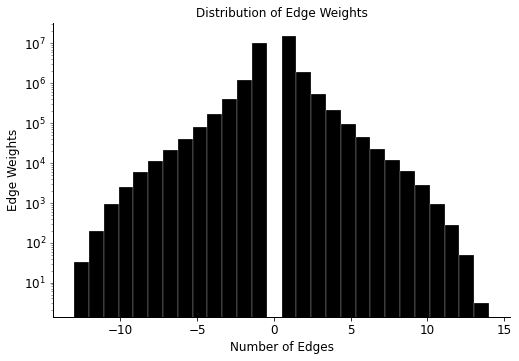

In [41]:
fig , ax = plt.subplots()

n , bins , patches = plt.hist(edge_weight_array , bins = 28 , color = 'k' , rwidth = 1.0 , edgecolor='white', linewidth=0.25)

plt.title('Distribution of Edge Weights', fontsize = 12, color = 'k')
plt.xlabel('Number of Edges', fontsize = 12, color = 'k')
plt.ylabel('Edge Weights' , fontsize = 12, color = 'k')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(False)
ax.set_yscale('log')

ax.tick_params(labelcolor = 'k')

fig = plt.gcf()
fig.set_size_inches(7.5, 5.25)
fig.tight_layout()

plt.tick_params(axis='y', which='major', labelsize=12 , labelcolor = 'k')
plt.tick_params(axis='x', which='major', labelsize=12 , labelcolor = 'k')

#file_name = '/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/Figures/lab_meeting_12_12_19/pairwise_SNP_distance/distribution_of_pairwise_SNP_distances.png'
#plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)

plt.show()

### Construct NetworkX graph from edge weight matrix

Test Graph construction on a **subset** of the edge weight matrix

In [42]:
#network_edge_weight_matrix_test = network_edge_weight_matrix[0:1000 , 0:1000]

In [65]:
#network_edge_weight_matrix_test
network_edge_weight_matrix

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int8)

In [66]:
#np.shape(network_edge_weight_matrix_test)
np.shape(network_edge_weight_matrix)

(30641, 30641)

In [45]:
#network_edge_weight_matrix_labels_test = network_edge_weight_matrix_labels[0:1000]

In [67]:
#network_edge_weight_matrix_labels_test.head()
network_edge_weight_matrix_labels.head()

0       DUSP5
1        FBP2
2    C15orf37
3         PHB
4      ZNF689
dtype: object

#### Retrieve the indices for the upper-triangular part of the matrix

In [84]:
abs(upper_tri_network_edge_weight_matrix)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int8)

In [113]:
#Return the upper triangular part of the matrix with elements in lower part ZEROED out
upper_tri_network_edge_weight_matrix = np.triu(network_edge_weight_matrix, k = 0)

#Return a boolean for elements in the upper triangular part of the matrix for elments that are <= -6 OR >= 6
upper_tri_network_edge_weight_matrix_bool = abs(upper_tri_network_edge_weight_matrix) >= 6

#get the indices for the elements in the upper triangle where elements (edge weights) <= -6 OR >= 6
node_i_indices = upper_tri_network_edge_weight_matrix_bool.nonzero()[0]
node_j_indices = upper_tri_network_edge_weight_matrix_bool.nonzero()[1]

#Create list of edges for NetworkX graph by iterating through numpy (adjancency) matrix (with edge weights) + node labels (rows/columns of matrix) & storing edges with weights <= -6 OR >= 6
G_edge_list = [ (network_edge_weight_matrix_labels[node_i], network_edge_weight_matrix_labels[node_j], network_edge_weight_matrix[node_i, node_j]) for node_i, node_j in zip(node_i_indices, node_j_indices)]

In [114]:
G_edge_list[0:5]

[('IL23A', 'IL23A', 9),
 ('IL23A', 'MYL9', -7),
 ('IL23A', 'MYBPC3', -6),
 ('IL23A', 'ITK', 7),
 ('IL23A', 'LTF', -6)]

In [115]:
len(G_edge_list) #number of edges (gene-gene pairs with edge weights <= -6 OR >= 6)

171673

#### Construct NetworkX graph from list of Edges

In [118]:
G = nx.Graph()
G.add_weighted_edges_from(G_edge_list)

In [119]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 1000
Number of edges: 171673
Average degree: 343.3460


#### Calculation Degree Centrality from NetworkX graph (doesn't take edge weights into account)

In [120]:
centrality = nx.degree_centrality(G)

In [121]:
centrality = pd.Series(centrality)

In [128]:
for gene_i in centrality.sort_values(ascending = False).head(n = 25).index:
    print(gene_i)

FCGR1B
C1QB
HP
CCR7
ID3
BATF2
EPHA4
FBXO6
SERPING1
IL7R
IFITM3
S1PR1
CLEC4D
EPSTI1
FLVCR2
SMARCD3
ASGR2
ANKRD22
GBP5
ETV7
NELL2
AIM2
PLEKHA1
SLC26A8
TMEM204


## Extra Stuff Below

In [24]:
#Convert edge weight numpy array to DataFrame
ATB_v_LTBI_network_edge_weight_df = pd.DataFrame(ATB_v_LTBI_network_edge_weight_matrix , index = ATB_v_LTBI_network_edge_weight_matrix_labels , columns = ATB_v_LTBI_network_edge_weight_matrix_labels)

### Agglomerative Clustering of genes by edge weights

In [ ]:
#cluster
gene_edge_weight_link = fastcluster.linkage_vector(ATB_v_LTBI_network_edge_weight_matrix, method='single', metric='euclidean')

#get the new order of the genes
gene_order = hier.leaves_list(gene_edge_weight_link)

#re-order the pairwise SNP distance matrix according to the new clustering order
reordered_data_subset = ATB_v_LTBI_network_edge_weight_matrix[gene_order, :]
reordered_data_subset = reordered_data_subset[:, gene_order]

Get the gene list according to the re-ordered edge weights array

In [ ]:
ATB_v_LTBI_network_edge_weight_matrix_labels = ATB_v_LTBI_network_edge_weight_matrix_labels[gene_order]

In [ ]:
ATB_v_LTBI_network_edge_weight_matrix_labels.head()

### Heatmap of gene edge weights on clustered matrix

In [ ]:
fig = plt.figure(figsize=(8, 8), dpi=300)
gs = gridspec.GridSpec(3, 3,
                       width_ratios=[1.5,10,0.25],
                       height_ratios=[1.5,10,0.25],
                       wspace=0.03,
                       hspace=0.03)

# # x ywidth height
ax1 = fig.add_subplot(gs[0,1], frameon=False)
Z1 = dendrogram(Z=gene_edge_weight_link, color_threshold=None, leaf_rotation=45, link_color_func=lambda x: link_cols[x] , no_labels = True , orientation='top', ax=ax1) # adding/removing the axes
ax1.set_xticks([])
ax1.set_yticks([])

ax2 = fig.add_subplot(gs[1,0], frameon=False)
Z2 = dendrogram(Z=gene_edge_weight_link, color_threshold=None, leaf_rotation=45, link_color_func=lambda x: link_cols[x] , no_labels = True , orientation='left', ax=ax2) # adding/removing the axes
ax2.set_xticks([])
ax2.set_yticks([])

axmatrix = fig.add_subplot(gs[1,1])
# norm=mpl.colors.Normalize(vmin=0, vmax=40)
im = axmatrix.matshow(reordered_data_subset.T, aspect='auto', origin='lower', cmap=plt.cm.Greys_r, interpolation='none')

ax_cbar = fig.add_subplot(gs[1,2])
cbar = plt.colorbar(im , cax = ax_cbar)
cbar.set_label('Gene Edge Weight' , rotation = -90, va='bottom')

axmatrix.set_xticks([])
axmatrix.set_yticks([])

fig.tight_layout()
#file_name = '/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/FOR_CHANG_pairwise_SNP_distance/figures/isolates_genetic_aggl_clustered.pdf'
#plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)

plt.show()